In [18]:
import pandas as pd
import hdbscan
import umap
import numpy as np
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

In [3]:
df = pd.read_csv("Tweets06112021.csv")
df = df.loc[df['Retweeting'] == "$"]
df.index = np.arange(0, len(df))
df.head()

,Unnamed: 0,Name,Twitter Handle,Time,Content,Retweeting,Hashtags,Tagged,Links
0,0,Jerry Carl,RepJerryCarl,2021-06-11T21:53:16.000Z,I’ll be live on Newsmax with Sean Spicer in ju...,$,$,$,https://t.co/GmdKC6Vwc9
1,1,Jerry Carl,RepJerryCarl,2021-06-11T17:11:19.000Z,"Thank you @RepHarshbarger, @RepRickCrawford, @...",$,$,"RepHarshbarger, RepRickCrawford, RepRonnyJacks...",$
2,2,Jerry Carl,RepJerryCarl,2021-06-11T17:10:10.000Z,🚨🚨 I just sent a letter to Speaker Pelosi urgi...,$,$,$,https://t.co/uyOQnL6qYO
3,3,Jerry Carl,RepJerryCarl,2021-06-11T15:37:00.000Z,Border crossings rose AGAIN last month. \n\nI’...,$,BidenBorderCrisis,$,https://t.co/UR0W4UHtUY
4,4,Jerry Carl,RepJerryCarl,2021-06-10T22:18:06.000Z,Tina and I are heartbroken to hear @RepTerriSe...,$,$,RepTerriSewells,https://t.co/fm6XIO9FGL


In [4]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [10]:
data = df["Content"]
h_embs = []
c_embs = []
for i in range(len(data)):
    print(100*(i/len(data)), end = "\r")
    c_embs.append(model.encode(data[i], show_progress_bar = False))
    if df["Hashtags"][i] == "$":
        h_embs.append(np.zeros((768)))
    else:
        h_embs.append(model.encode(df["Hashtags"][i]))
    
h_embs = np.array(h_embs)
c_embs = np.array(c_embs)

In [30]:
np.save("6_11_21_corpus_embeddings", c_embs)
np.save("6_11_21_hashtag_embeddings", h_embs)

In [11]:
c_umap_embeddings = umap.UMAP(n_neighbors = 15, n_components = 20, metric = 'cosine').fit_transform(c_embs)
h_umap_embeddings = umap.UMAP(n_neighbors = 15, n_components = 4, metric = 'cosine').fit_transform(h_embs)
print(c_umap_embeddings.shape)
print(h_umap_embeddings.shape)

(8319, 20)
(8319, 4)


In [13]:
umap_embeddings = np.concatenate([c_umap_embeddings, h_umap_embeddings], axis=1)
umap_embeddings.shape

(8319, 24)

In [14]:
cluster = hdbscan.HDBSCAN(min_cluster_size=12, metric = 'euclidean', cluster_selection_method='eom').fit(umap_embeddings)

[[-6.9107633   0.75506514]
 [-6.886768    0.35036862]
 [-5.728921    0.6429259 ]
 ...
 [-4.715546    0.20347032]
 [-6.8194194  -0.2344225 ]
 [-4.8054185  -0.06090172]]


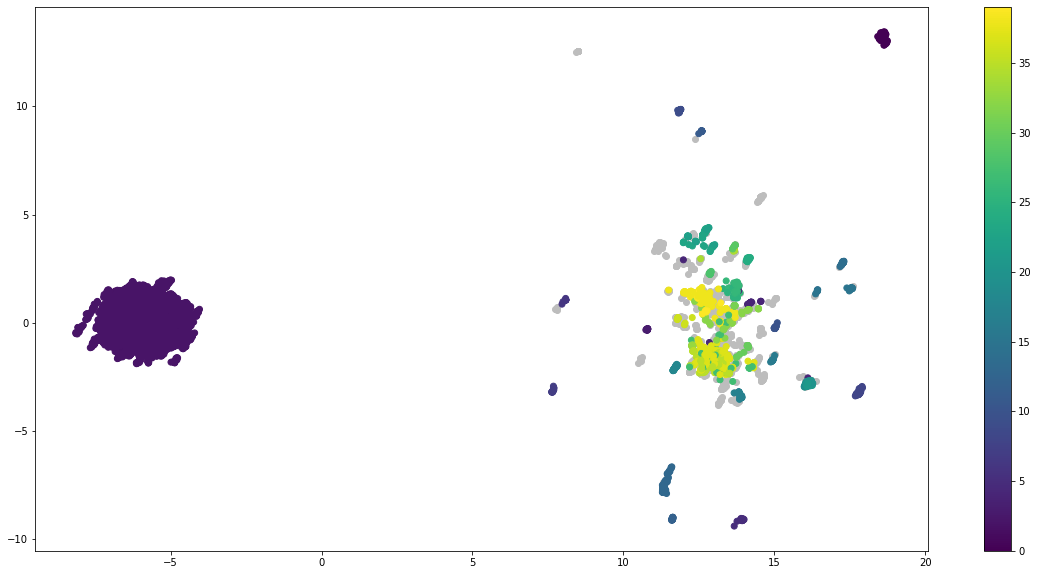

In [22]:
import matplotlib.pyplot as plt

pca = PCA(n_components = 2)
umap_data = pca.fit_transform(umap_embeddings)
print(umap_data)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

plt.scatter(outliers.x, outliers.y, color = "#BDBDBD")
plt.scatter(clustered.x, clustered.y, c = clustered.labels)
plt.colorbar()

plt.show()

In [38]:
for tweet in df.iloc[(cluster.labels_ == 9).nonzero()].Content:
    print(tweet, "\n\n\n")

The #INVESTAct is a game-changing, long-term investment in Arizona that creates jobs, drives our economic recovery, fights climate change and lifts Native American communities.

Here's what's in it for Arizona ⬇️ https://t.co/zC8C47xJFe 



Early this morning @TransportDems passed the #INVESTAct with bipartisan support—including 6 of my local project requests. These funds will make a real difference in our communities by expanding public transit, building + repairing roads on tribal lands, and improving road safety. https://t.co/Gfj38G5zlk 



WATCH: The #INVESTAct is bold and transformative, and the exact investment we need now to compete in the 21st century economy. 

It would expand public transit in communities that need it, build and repair roads on tribal lands, support sustainable construction, and create jobs. https://t.co/kQdg42fiF8 



We need bold infrastructure investment to compete in the 21st century economy, improve quality of life, and make it safer and easier to get ar

In [36]:
for i in np.unique(cluster.labels_):
    print(i, (cluster.labels_ == i).sum())

-1 1011
0 92
1 25
2 5753
3 39
4 30
5 83
6 14
7 23
8 74
9 25
10 24
11 27
12 24
13 95
14 41
15 36
16 23
17 26
18 37
19 14
20 37
21 41
22 30
23 32
24 49
25 18
26 66
27 45
28 17
29 21
30 20
31 19
32 30
33 13
34 15
35 79
36 15
37 118
38 124
39 14


In [40]:
np.save("6_11_21_cluster_labels", cluster.labels_)

In [34]:
np.unique(cluster.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39])

In [41]:
pca = PCA(n_components = 3)
umap_data = pca.fit_transform(umap_embeddings)
print(umap_data)

[[-6.9107466   0.7550116   1.2176484 ]
 [-6.8867674   0.3503685   1.904355  ]
 [-5.7289205   0.64292264  0.71334517]
 ...
 [-4.715545    0.20346873 -1.8522478 ]
 [-6.819419   -0.23442104  0.89370275]
 [-4.8054175  -0.06089579  3.9155169 ]]


In [43]:
np.save("6_11_21_topics3dPCA", umap_data)

In [44]:
umap_data.shape

(8319, 3)

In [45]:
umap_embeddings.shape

(8319, 24)